# Names
Load name data from SSA.gov dataset.

In [2]:
import io, os, requests, zipfile

url="https://www.ssa.gov/oact/babynames/names.zip"
directory="./data/"
namesDirectory=os.path.join(directory, "names")

if not os.path.exists(namesDirectory):
    r = requests.get(url)
    assert r.ok
    with zipfile.ZipFile(io.BytesIO(r.content)) as zip:
        zip.extractall(namesDirectory)

Combine the yearly data into a single CSV. Filter to a single gender while we're at it, mostly because it simplifies the name key in the dictionary I'm using to combine data.


In [92]:
startYear=1921
endYear=2021
desiredSex="F"

combined_filename=os.path.join(directory, f"combined-{startYear}-{endYear}-{desiredSex}.csv")
if not os.path.exists(combined_filename):

    # Read all the names from each year between start..end
    #    1. Filter to one gender
    #    2. Create a column for the name frequency each year
    #    3. Write to a new csv file
    all_the_names={}
    for year in range(startYear, endYear + 1):
        filename=os.path.join(namesDirectory, f"yob{year}.txt")
        with open(filename, "r") as names:
            for line in names:
                name, sex, number = line.split(",")
                if sex != desiredSex:
                    continue

                name = str.strip(name)
                if name not in all_the_names.keys():
                    all_the_names[name] = {}

                all_the_names[name][year] = str.strip(number)
    
    with open(combined_filename, "w") as combined:
        combined.write("Name")
        for year in range(startYear, endYear + 1):
            combined.write(f",{year}")
        combined.write("\n")

        for name, numbers in all_the_names.items():
            combined.write(str.strip(name))
            for year in range(startYear, endYear + 1):
                yearNumber = 0 if year not in numbers.keys() else numbers[year]
                combined.write(f",{yearNumber}")
            combined.write("\n")

Load the combined file. Add columns for each year representing:
* Yearly name rank 
* Name percent of samples
* Approximate # of people with this name per 1 million 

In [103]:
import numpy as np
import pandas as pd

df = pd.read_csv(combined_filename)
# for year in range(startYear, endYear + 1):
#     df = df.sort_values(by=f"{year}", ascending=False)
#     df[f"{year}_rank"] = df.reset_index(drop=True).index + 1    
#     df[f"{year}"].map((1_000_000 * df[f"{year}"] / df[f"{year}"].sum()).round().astype(int))

# normalize count as 'count per million' (I guess - I don't know how normalized this data is)
df = pd.concat([s if name == "Name" else (1_000_000 * s / s.sum()).round().astype(int) for name, s in df.items()], axis=1)
df = df.set_index('Name')

## Top 2021 - Last 30 Years
Plot the popularity of the top 10 names from 2021 since 1991.

<AxesSubplot: title={'center': 'Most Popular Names of 2021'}, ylabel='Count per Million'>

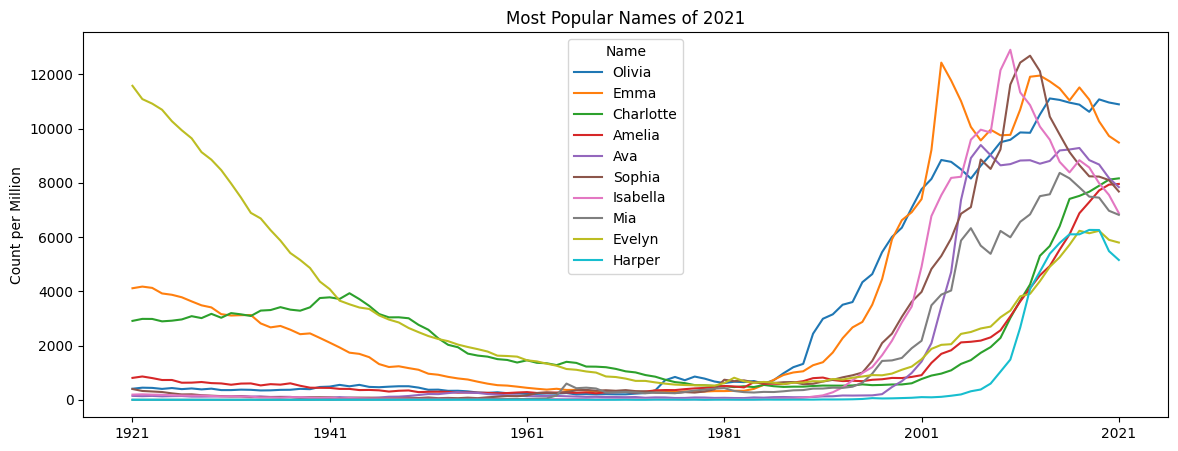

In [105]:
topTen2021 = df.nlargest(10, '2021')

topTen2021.transpose().plot(title="Most Popular Names of 2021", ylabel="Count per Million", figsize=(14,5))

## Top 1991 - Next 30 Years
Plot the popularity of the top names from 1991 to 2021.

<AxesSubplot: title={'center': 'Most Popular Names of 1991'}, ylabel='Count per Million'>

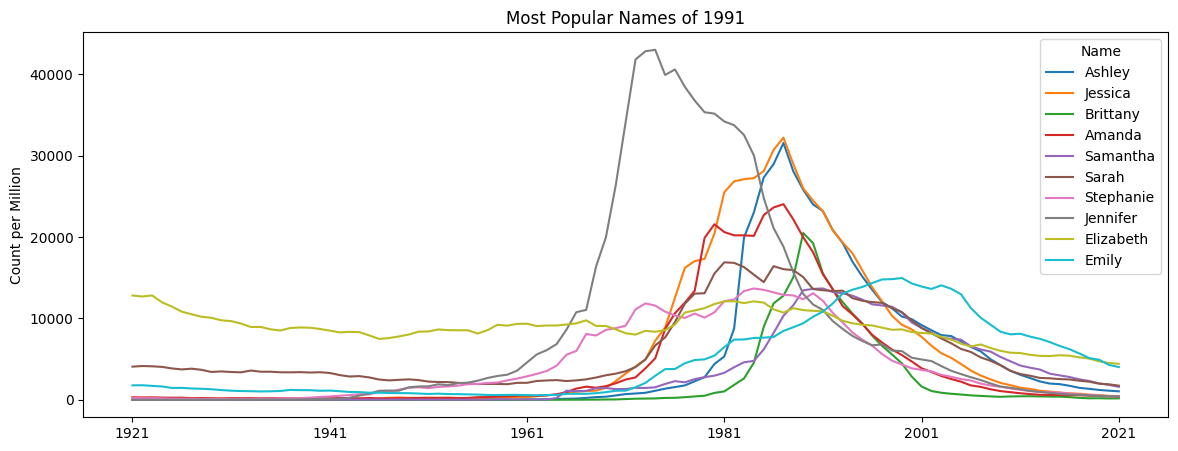

In [108]:
topTen1991 = df.nlargest(10, '1991')

topTen1991.transpose().plot(title="Most Popular Names of 1991", ylabel="Count per Million", figsize=(14,5))

<AxesSubplot: title={'center': "Popularity of 'Daphne'"}, ylabel='Count per Million'>

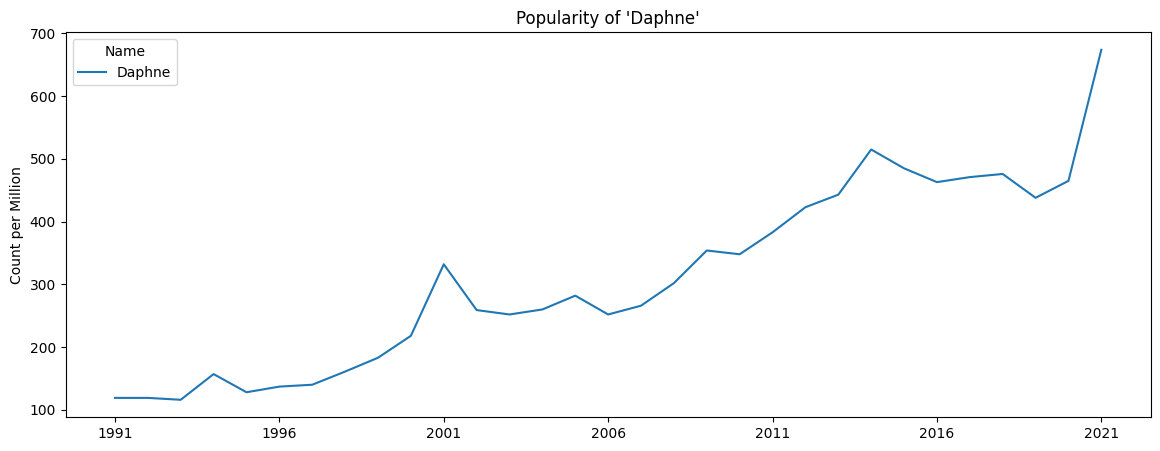

In [91]:
name = 'Daphne'
plotName = df[df.index == name]

plotName.transpose().plot(title=f"Popularity of '{name}'", ylabel="Count per Million", figsize=(14,5))